# About this notebook:
---
1) In the first part we will go over the use of K-means ++ including its medoid version, and PCA


2) In the second part we will see how to use DBScan and Hierarchical Clustering and also t-SNE


# Library

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from termcolor import colored #freak library
from scipy import stats
from sklearn import preprocessing
from pandas import DataFrame
from sklearn.cluster import KMeans
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids
!pip install fuzzy-c-means
from fcmeans import FCM
from sklearn.decomposition import PCA 
import os
from sklearn.cluster import DBSCAN
from itertools import product
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE

os.chdir('/content/drive/MyDrive/ML-LAB/Code/Unsupervised')
pd.options.mode.chained_assignment = None 

# First Part

## Data

In [ ]:
data = pd.read_csv("wine.data", names=['Class', 
                                      'Alcohol', 
                                      'Malic acid',
                                      'Ash',
                                      'Alcalinity of ash' ,
                                      'Magnesium', 
                                      'Total phenols',
                                      'Flavanoids' ,
                                      'Nonflavanoidphenols', 
                                      'Proanthocyanins',
                                      'Color intensity',
                                      'Hue',
                                      'OD280/OD315 DW',
                                      'Proline'])
data.head(5)

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoidphenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 DW,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Some information:  
### These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars.
### The analysis determined the quantities of 13 constituents found in each of the three types of wines.

## **The aim is to find similar wines according to their characteristics**

## EDA
### now let's start with some basic exploration and visualization of the data

In [ ]:
# Columns type

print(colored('Before \n', attrs=['bold']))
print(data.info(),'\n')

#let's change 'Class' from int to cateogry

data['Class'] = data['Class'].astype('category')

#See the difference ? 

print(colored('After \n', attrs=['bold']))
print(data.info(),'\n')
print('Number of rows and column ->',colored(data.shape, 'red'))

Before 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Class                178 non-null    int64  
 1   Alcohol              178 non-null    float64
 2   Malic acid           178 non-null    float64
 3   Ash                  178 non-null    float64
 4   Alcalinity of ash    178 non-null    float64
 5   Magnesium            178 non-null    int64  
 6   Total phenols        178 non-null    float64
 7   Flavanoids           178 non-null    float64
 8   Nonflavanoidphenols  178 non-null    float64
 9   Proanthocyanins      178 non-null    float64
 10  Color intensity      178 non-null    float64
 11  Hue                  178 non-null    float64
 12  OD280/OD315 DW       178 non-null    float64
 13  Proline              178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB
None 

After 

<class 'pandas.core

In [ ]:
# check if the are some missing value

print(data.isnull().sum(),colored('\n\n No missing Data lucky day!','green'))

Class                  0
Alcohol                0
Malic acid             0
Ash                    0
Alcalinity of ash      0
Magnesium              0
Total phenols          0
Flavanoids             0
Nonflavanoidphenols    0
Proanthocyanins        0
Color intensity        0
Hue                    0
OD280/OD315 DW         0
Proline                0
dtype: int64 

 No missing Data lucky day!


In [ ]:
# data distribution numeric

data._get_numeric_data().describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
Malic acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
Ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
Alcalinity of ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
Magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
Total phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
Flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
Nonflavanoidphenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
Proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
Color intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


In [ ]:
#data distribution class category

data.Class.value_counts().sort_index()

1    59
2    71
3    48
Name: Class, dtype: int64

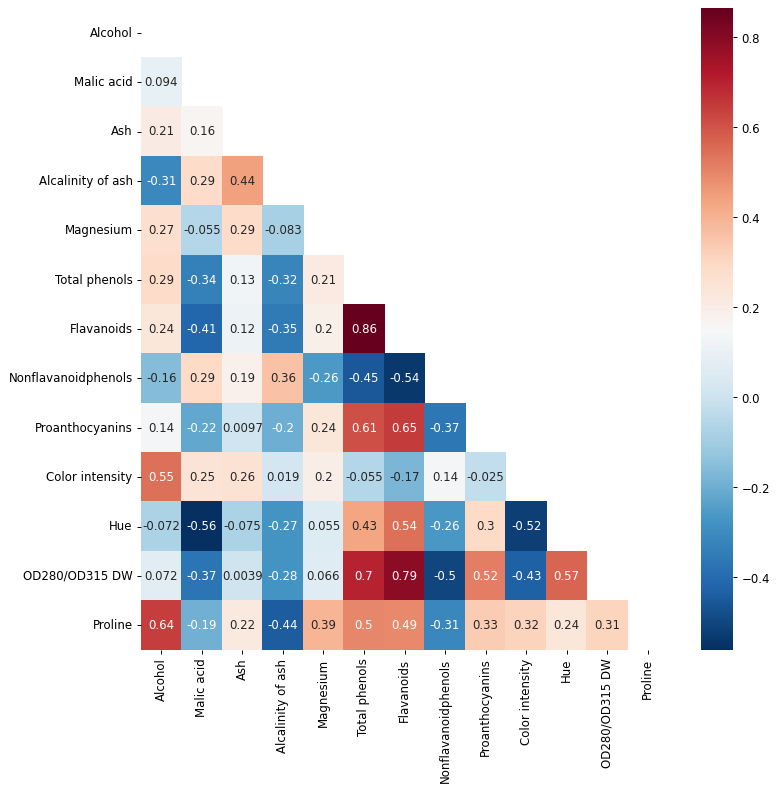

In [ ]:
# correlation matrix

plt.figure(figsize=(10,10))
mask = np.triu(np.ones_like(data.corr()))
sns.heatmap(data.corr(), annot=True, mask = mask, cmap ="RdBu_r");

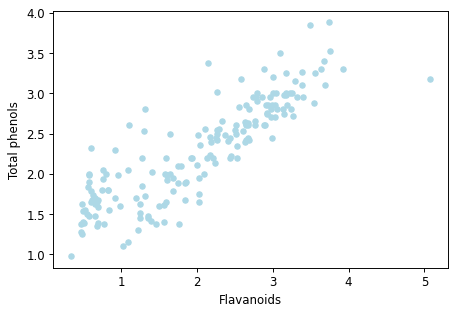

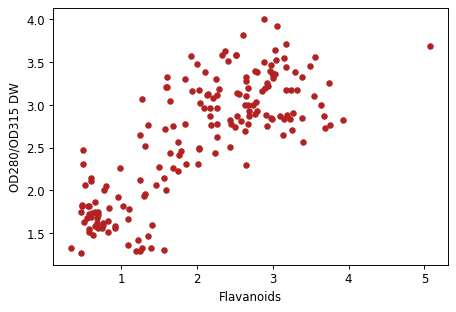

In [ ]:
# let's plot the most correlated variable

data.plot(kind= 'scatter', x= 'Flavanoids', y='Total phenols', c= 'lightblue')
data.plot(kind= 'scatter', x= 'Flavanoids', y='OD280/OD315 DW', c= 'firebrick')
plt.show()

It would seem that there are some outliers in the dataset, are they the only ones? If so, how could it be solved?

&nbsp; 

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

Why not use the z score? 
&nbsp;

A nice way is to assume that the distribution of data X has a mean $\mu$ and a sd $\sigma$. The z-score measures how many values are distant from $\mu$. 

In [ ]:
data_no_out = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

print('Original data shape', data.shape,'No outlier data shape',data_no_out.shape) 
data_no_out.reset_index(inplace = True, drop = True )

Original data shape (178, 14) No outlier data shape (168, 14)


We choose to use 3 because we assume that we want to take data at most 3$σ$ times distant from the mean. More [here](https://sixsigmastudyguide.com/z-scores-z-table-z-transformations/)

Now it's the moment to standardize our data and put aside *Class*, you know why...

In [ ]:
X = data_no_out.iloc[:,1:]

#standardize 

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

### ... and use PCA!

In [ ]:
# creates an instance of PCA class

pca = PCA() 

# applies PCA 

principalComponents = pca.fit_transform(X) 


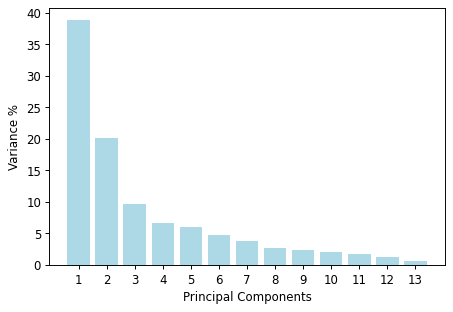

In [ ]:
# Plotting the variances for each PC

PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_*100, color='lightblue')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)


# Putting components in a dataframe for later

PCA_components = pd.DataFrame(principalComponents)

The  plot above is called a scree plot. It shows the variances explained by each latent variable. The first component explains approx. 40% of the variance in the whole dataset.



In [ ]:
just_for_visualization = pd.concat([PCA_components.loc[:,:1].rename(columns={0:'PC1',1:'PC2'}), data_no_out[['Class']]], axis = 1)

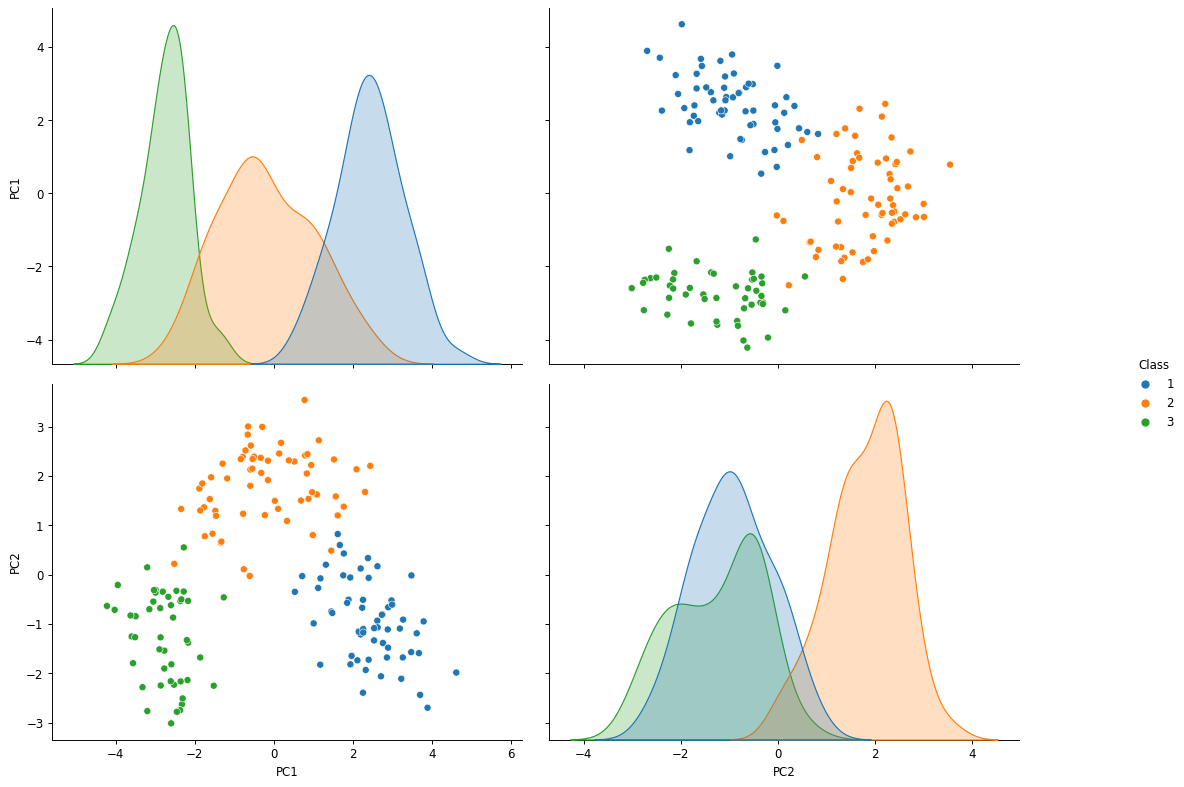

In [ ]:
pca = sns.pairplot(vars = ['PC1', 'PC2'] , data = just_for_visualization, hue = 'Class')
pca.fig.set_size_inches(15,10)
plt.show()

Awesome ! PCA has helped us to reduce the dimension of our data and we were able to make this nice plot. As we can see, extracting principal components, instead of randomly picking variables, allows us to perfectly recognize the clustering pattern defined by the pre-existing "Class" attribute. Our aim, at this point, will be that of verifying if a K-means algorithm can succeed in reproducing the same result.



### Now it's time for Clustering!

#### K-mean

#### K-mean ++

In [ ]:
inertias = [] # our WSS
ks = range(1, 10)
# Creating 10 K-Mean++ models while varying the number of clusters (k)
for k in range(1,10):
    model = KMeans(n_clusters = k, init = 'k-means++', n_init = 1, random_state = 0)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
  

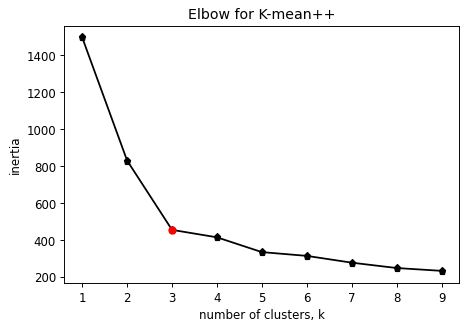

In [ ]:
plt.plot(range(1,10), inertias, '-p', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.plot(3,inertias[2],'ro')
plt.xticks(ks)
plt.title('Elbow for K-mean++')
plt.show()


Typically, we look at these inertia plots above to find the elbow point. Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. A good model is one with low inertia AND a low number of clusters (K).
In our case, it looks like the elbow occurs with 3 clusters, so we will proceed with that.

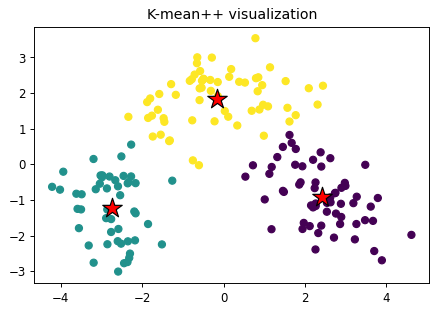

[[ 2.40965897 -0.91245968]
 [-2.75161974 -1.22451646]
 [-0.16544478  1.84609691]]


In [ ]:
model = KMeans(n_clusters=3, init = 'k-means++', n_init = 1)
model.fit(PCA_components.iloc[:,:2])

# coordinates of cluster center
centroids = model.cluster_centers_ 

# cluster label for each data point
labels = model.labels_ 

plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.scatter( centroids[:, 0], centroids[:, 1], s=300, marker='*', c='red', edgecolor='black')
plt.title('K-mean++ visualization')
plt.show()


print(centroids[:,0:2])

In [ ]:
data_no_out['clusters'] = labels
data_no_out.groupby(["clusters"]).agg({
    'Alcohol': 'median', 
    'Color intensity': 'median', 
    'Malic acid': 'median', 
    'Magnesium': 'median',
    'Ash' : 'median',
    'Total phenols' : 'median',
    'Proline' : 'median'})

,Alcohol,Color intensity,Malic acid,Magnesium,Ash,Total phenols,Proline
clusters,,,,,,,
0,13.750,5.40,1.760,104.0,2.43,2.800,1095.0
1,13.135,7.40,3.285,96.5,2.38,1.635,622.5
2,12.290,2.94,1.610,88.0,2.27,2.200,480.0


#### K-Medoids

In [ ]:
# Compute Kmedoids clustering
inertias = [] # our WSS
ks = range(1, 10)
# Creating 10 K-Medoids models while varying the number of clusters (k)
for k in range(1,10):
    model = KMedoids(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
  

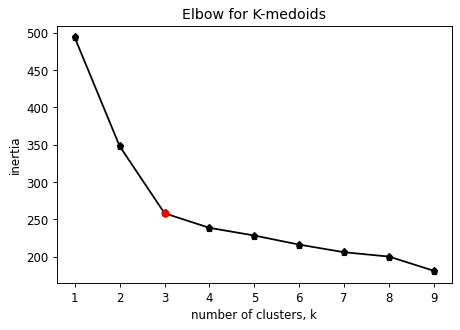

In [ ]:
plt.plot(range(1,10), inertias, '-p', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.plot(3,inertias[2],'ro')
plt.xticks(ks)
plt.title('Elbow for K-medoids')
plt.show()

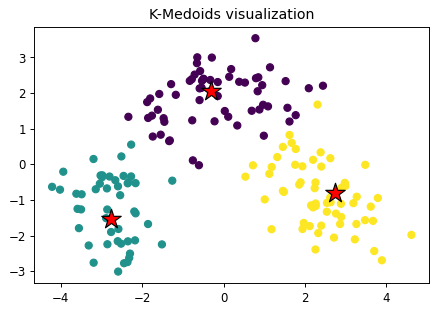

[[-0.31196241  2.06356365]
 [-2.76412272 -1.53800509]
 [ 2.74031831 -0.81111308]]


In [ ]:
model =  KMedoids(n_clusters=3)
model.fit(PCA_components.iloc[:,:3])

# coordinates of cluster center
centroids = model.cluster_centers_ 

# cluster label for each data point
labels = model.labels_ 

plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.scatter( centroids[:, 0], centroids[:, 1], s=300, marker='*', c='red', edgecolor='black')
plt.title('K-Medoids visualization')
plt.show()

print(centroids[:,0:2])

In [ ]:
data_no_out['clusters'] = labels
data_no_out.groupby(["clusters"]).agg({
    'Alcohol': 'median', 
    'Color intensity': 'median', 
    'Malic acid': 'median', 
    'Magnesium': 'median',
    'Ash' : 'median',
    'Total phenols' : 'median',
    'Proline' : 'median'})

,Alcohol,Color intensity,Malic acid,Magnesium,Ash,Total phenols,Proline
clusters,,,,,,,
0,12.270,2.92,1.620,88.0,2.275,2.200,476.0
1,13.135,7.40,3.285,96.5,2.380,1.635,622.5
2,13.745,5.40,1.755,103.5,2.425,2.825,1087.5


So, we learned that the KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (WSS).

# Second Part

In [ ]:
mall_data = pd.read_csv('Mall_Customers.csv')

In [ ]:
mall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
mall_data.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [ ]:
mall_data['Gender'].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

In [ ]:
### play alone 

# --- DO an EDA --- 

## DBScan

In [ ]:
X = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

### To choose the best combination of the algorithm parameters we will first create a matrix of investigated combinations.

In [ ]:

# eps values to be investigated
eps_values = np.arange(8,12.75,0.25)

# min_samples values to be investigated
min_samples = np.arange(3,10) 

#define DBScan parameter
DBScan_params = list(product(eps_values, min_samples))

In [ ]:
# Collecting number of generated clusters
no_of_clusters = []
sil_score = []

for p in DBScan_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X, DBS_clustering.labels_))

With the heatmap we can evaluate which are the best parameters to choose to build our clustering. 
But first a little explanation:
Silhouette score is a metric used to calculate the goodness of a clustering technique. It has a range between (-1,1)



*   1: Means clusters are well apart from each other and clearly distinguished
*   0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
*  -1: Means clusters are assigned in the wrong way.



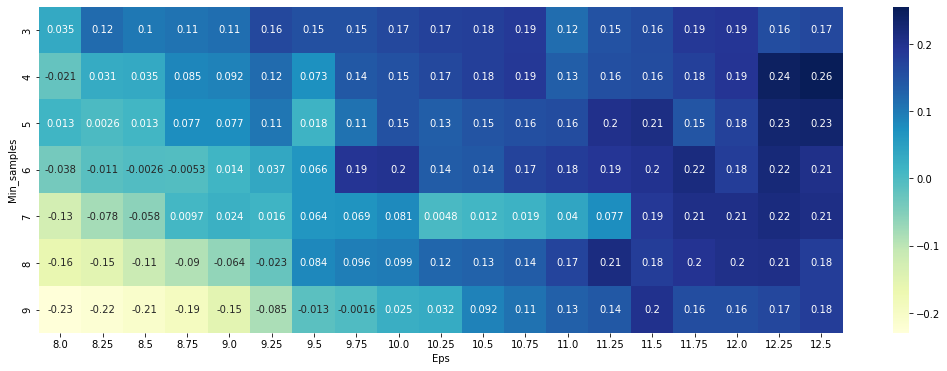

In [ ]:
tmp = pd.DataFrame.from_records(DBScan_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

After going blind, we will see that the maximum is found for a silhuoette score of 0.26 , eps = 12.5 and min_samples = 4

In [ ]:
#let's apply for the parameter found
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X)

DBSCAN_clustered = X.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ 

In [ ]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


DBSCAN created 5 clusters plus outliers cluster (-1). Sizes of clusters 0-4 vary significantly - some have only 4 or 8 observations. There are 18 outliers.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


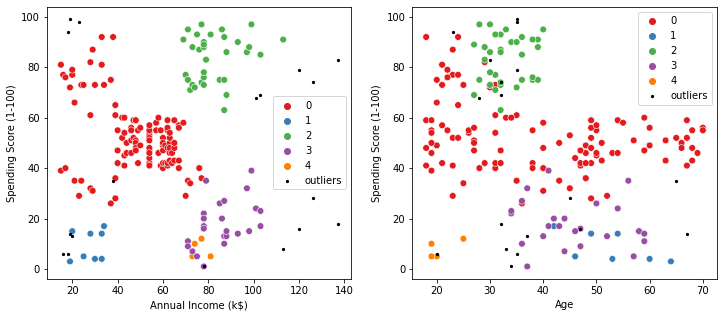

In [ ]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot('Age', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

The graph above shows that there are some outliers.
These points do not meet distance and minimum samples requirements to be recognised as a cluster.

## Hierarchical Clustering

In [ ]:
X = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

#standardize 
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [ ]:
parameters=['ward', 'complete', 'average', 'single']
n_clusters=np.arange(1,10)
agh_cluster_results_ = pd.DataFrame(columns=['Linkage Type','Number of Cluster','Silhouette Score'])
for i in parameters:
    for j in n_clusters:
        agh_cluster=AgglomerativeClustering(n_clusters=j,linkage=i)
        clusters=agh_cluster.fit_predict(X)
        if len(np.unique(clusters))>=2:
            agh_cluster_results_ = agh_cluster_results_.append({"Linkage Type":i,'Number of Cluster':j,
                                    "Silhouette Score":silhouette_score(X,clusters)}                                   
                                   ,ignore_index=True)

In [ ]:
agh_cluster_results_.sort_values('Silhouette Score',ascending=False)[:10]

,Linkage Type,Number of Cluster,Silhouette Score
4,ward,6,0.420117
19,average,5,0.409569
23,average,9,0.406859
11,complete,5,0.399982
5,ward,7,0.398295
10,complete,4,0.390139
3,ward,5,0.390028
20,average,6,0.389573
18,average,4,0.383906
21,average,7,0.380044


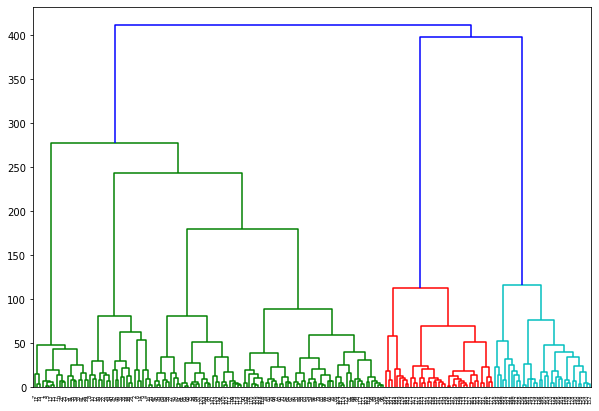

In [ ]:
# Using Ward's method
linked = linkage(X, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

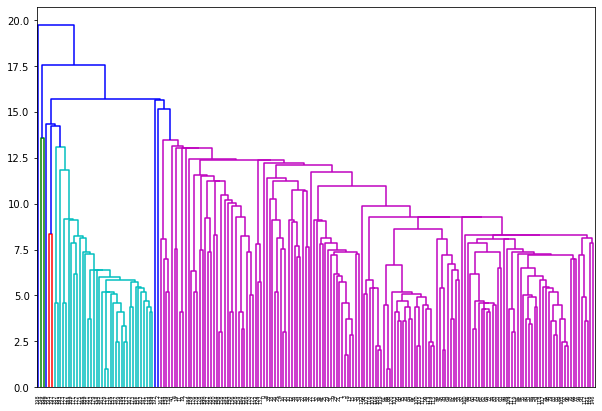

In [ ]:
# Using Single link method
linked = linkage(X, 'single')

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

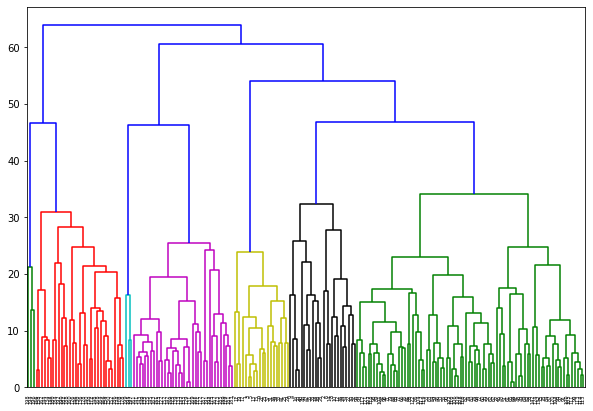

In [ ]:
# Using Average method
linked = linkage(X, 'average')

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

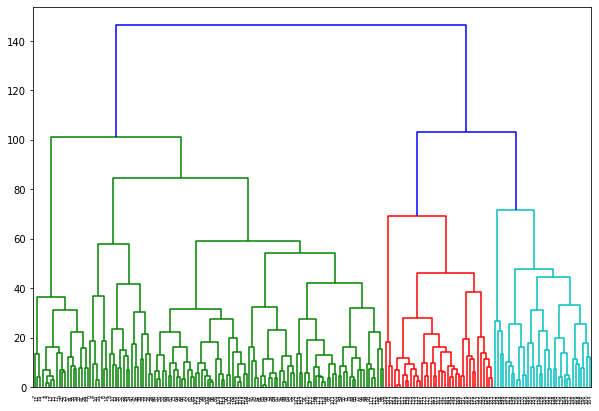

In [ ]:
# Using Complete link method
linked = linkage(X, 'complete')

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

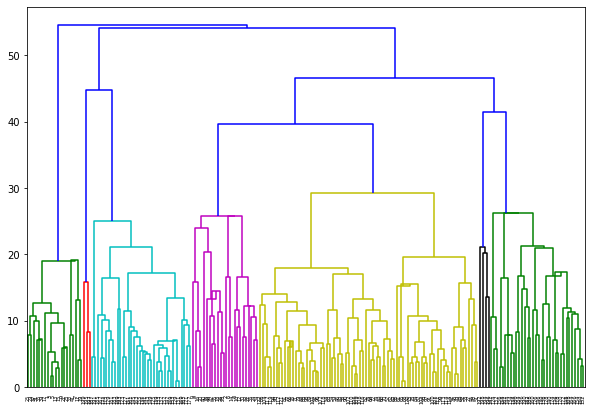

In [ ]:
# Using Centroids  link method
linked = linkage(X, 'centroid')

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

## t-SNE

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 14.908652
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.240273
[t-SNE] KL divergence after 1000 iterations: 0.195249


Considering DBScan Labels

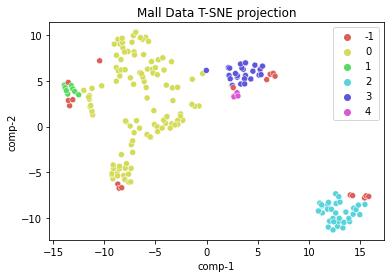

In [ ]:
df = pd.DataFrame()
df["y"] = DBS_clustering.labels_ 
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 6),
                data=df).set(title="Mall Data T-SNE projection") 
plt.show()

Considering Gender Labels 

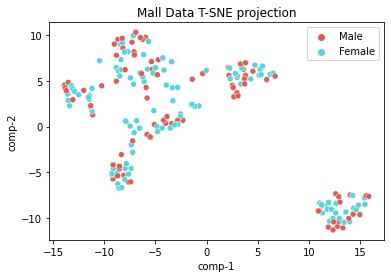

In [ ]:
df = pd.DataFrame()
df["y"] = mall_data['Gender']
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="Mall Data T-SNE projection") 
plt.show()

# Bonus Track

## Time for Fuzzy ❤

Fuzzy algorithm is a way to generalize the approach to consider the soft assignment of points to clusters so that each point has a probability of belonging to each cluster.

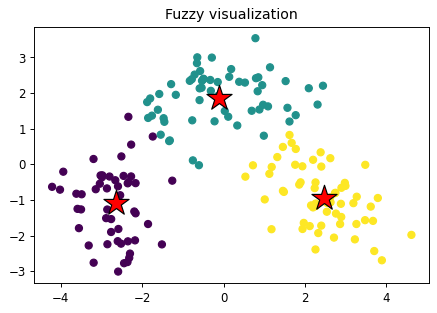

[[-2.64477795 -1.095694  ]
 [-0.11469263  1.85441958]
 [ 2.48135535 -0.95440748]]


In [ ]:
fcm = FCM(n_clusters=3)
fcm.fit(PCA_components.iloc[:,:3].values)
# outputs
fcm_centers = fcm.centers
fcm_labels = fcm.predict(PCA_components.iloc[:,:3].values)

plt.scatter(PCA_components[0], PCA_components[1],  c=fcm_labels)
plt.scatter( fcm_centers[:,0], fcm_centers[:,1], marker="*", s=500, c='red', edgecolor = 'black')
plt.title('Fuzzy visualization')
plt.show()

print(fcm_centers[:,0:2])

In [ ]:
data_no_out['clusters'] = fcm_labels
data_no_out.groupby(["clusters"]).agg({
    'Alcohol': 'median', 
    'Color intensity': 'median', 
    'Malic acid': 'median', 
    'Magnesium': 'median',
    'Ash' : 'median',
    'Total phenols' : 'median',
    'Proline' : 'median'})

,Alcohol,Color intensity,Malic acid,Magnesium,Ash,Total phenols,Proline
clusters,,,,,,,
0,13.095,7.2,3.285,96.5,2.375,1.64,617.5
1,12.250,2.9,1.610,88.0,2.280,2.20,488.0
2,13.750,5.4,1.760,104.0,2.430,2.80,1095.0


## Pyspark

In [ ]:
#!pip install pyspark
# Spark SQL
!pip install pyspark[sql]

In [ ]:
PCA_df = PCA_components.rename(columns= {0:'pc1', 1:'pc2', 2:'pc3'}).iloc[:,:3]
PCA_df['Class'] = data_no_out['Class']

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Clustering using K-Means').getOrCreate()
data=spark.read.csv("wine.data", header = False, inferSchema=True)
data = data.toDF('Class','Alcohol', 
                  'Malic acid',
                  'Ash',
                  'Alcalinity of ash' ,
                  'Magnesium', 
                  'Total phenols',
                  'Flavanoids' ,
                  'Nonflavanoidphenols', 
                  'Proanthocyanins',
                  'Color intensity',
                  'Hue',
                  'OD280/OD315 DW',
                  'Proline')
data.printSchema()

root
 |-- Class: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- Malic acid: double (nullable = true)
 |-- Ash: double (nullable = true)
 |-- Alcalinity of ash: double (nullable = true)
 |-- Magnesium: integer (nullable = true)
 |-- Total phenols: double (nullable = true)
 |-- Flavanoids: double (nullable = true)
 |-- Nonflavanoidphenols: double (nullable = true)
 |-- Proanthocyanins: double (nullable = true)
 |-- Color intensity: double (nullable = true)
 |-- Hue: double (nullable = true)
 |-- OD280/OD315 DW: double (nullable = true)
 |-- Proline: integer (nullable = true)



In [ ]:
from pyspark.ml.feature import VectorAssembler
data.columns
assemble=VectorAssembler(inputCols=['Class','Alcohol', 
                  'Malic acid',
                  'Ash',
                  'Alcalinity of ash' ,
                  'Magnesium', 
                  'Total phenols',
                  'Flavanoids' ,
                  'Nonflavanoidphenols', 
                  'Proanthocyanins',
                  'Color intensity',
                  'Hue',
                  'OD280/OD315 DW',
                  'Proline'], outputCol='features')
assembled_data=assemble.transform(data)
assembled_data.show(10)

+-----+-------+----------+----+-----------------+---------+-------------+----------+-------------------+---------------+---------------+----+--------------+-------+--------------------+
|Class|Alcohol|Malic acid| Ash|Alcalinity of ash|Magnesium|Total phenols|Flavanoids|Nonflavanoidphenols|Proanthocyanins|Color intensity| Hue|OD280/OD315 DW|Proline|            features|
+-----+-------+----------+----+-----------------+---------+-------------+----------+-------------------+---------------+---------------+----+--------------+-------+--------------------+
|    1|  14.23|      1.71|2.43|             15.6|      127|          2.8|      3.06|               0.28|           2.29|           5.64|1.04|          3.92|   1065|[1.0,14.23,1.71,2...|
|    1|   13.2|      1.78|2.14|             11.2|      100|         2.65|      2.76|               0.26|           1.28|           4.38|1.05|           3.4|   1050|[1.0,13.2,1.78,2....|
|    1|  13.16|      2.36|2.67|             18.6|      101|          2

In [ ]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit( assembled_data.select(assembled_data.columns[1:]))
data_scale_output=data_scale.transform(assembled_data.select(assembled_data.columns[1:]))
data_scale_output.show(10)

+-------+----------+----+-----------------+---------+-------------+----------+-------------------+---------------+---------------+----+--------------+-------+--------------------+--------------------+
|Alcohol|Malic acid| Ash|Alcalinity of ash|Magnesium|Total phenols|Flavanoids|Nonflavanoidphenols|Proanthocyanins|Color intensity| Hue|OD280/OD315 DW|Proline|            features|        standardized|
+-------+----------+----+-----------------+---------+-------------+----------+-------------------+---------------+---------------+----+--------------+-------+--------------------+--------------------+
|  14.23|      1.71|2.43|             15.6|      127|          2.8|      3.06|               0.28|           2.29|           5.64|1.04|          3.92|   1065|[1.0,14.23,1.71,2...|[1.29026432731673...|
|   13.2|      1.78|2.14|             11.2|      100|         2.65|      2.76|               0.26|           1.28|           4.38|1.05|           3.4|   1050|[1.0,13.2,1.78,2....|[1.29026432731673

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score for number of cluster = ",i,':', score)

Silhouette Score for number of cluster =  2 : 0.4376149515070152
Silhouette Score for number of cluster =  3 : 0.4817176067033942
Silhouette Score for number of cluster =  4 : 0.44908367916068137
Silhouette Score for number of cluster =  5 : 0.25364655839657324
Silhouette Score for number of cluster =  6 : 0.3623821489076269
Silhouette Score for number of cluster =  7 : 0.3415344076007823
Silhouette Score for number of cluster =  8 : 0.23116142525393701
Silhouette Score for number of cluster =  9 : 0.20740052518573715


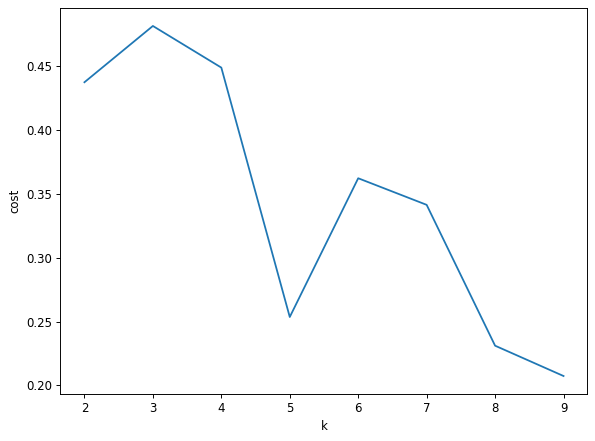

In [ ]:
#Visualizing the silhouette scores in a plot
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.show()

Even using pyspark and looking at the silhouette score confirms that the number of clusters of 3 is the best!